<a href="https://colab.research.google.com/github/DarshiniMH/Book-Recommendation-/blob/main/book_recommendations_item_to_item.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### loading Books dataset json.gz

This script reads a compressed JSON file of book data, extracts only the necessary fields from each book, and filters out books with fewer than 50 ratings. The selected book entries are saved as list and converted to pandas DataFrame for further use.

In [ ]:
# This code reads and print the first line from the gzip compressed json
# file which has book data
import gzip

with gzip.open("/content/drive/MyDrive/Book Recommendation/goodreads_books.json.gz","r") as f:
  line= f.readline()
  print(line)

b'{"isbn": "0312853122", "text_reviews_count": "1", "series": [], "country_code": "US", "language_code": "", "popular_shelves": [{"count": "3", "name": "to-read"}, {"count": "1", "name": "p"}, {"count": "1", "name": "collection"}, {"count": "1", "name": "w-c-fields"}, {"count": "1", "name": "biography"}], "asin": "", "is_ebook": "false", "average_rating": "4.00", "kindle_asin": "", "similar_books": [], "description": "", "format": "Paperback", "link": "https://www.goodreads.com/book/show/5333265-w-c-fields", "authors": [{"author_id": "604031", "role": ""}], "publisher": "St. Martin\'s Press", "num_pages": "256", "publication_day": "1", "isbn13": "9780312853129", "publication_month": "9", "edition_information": "", "publication_year": "1984", "url": "https://www.goodreads.com/book/show/5333265-w-c-fields", "image_url": "https://images.gr-assets.com/books/1310220028m/5333265.jpg", "book_id": "5333265", "ratings_count": "3", "work_id": "5400751", "title": "W.C. Fields: A Life on Film", "t

In [ ]:
import json
json.loads(line)

{'isbn': '0312853122',
 'text_reviews_count': '1',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.00',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Paperback',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'authors': [{'author_id': '604031', 'role': ''}],
 'publisher': "St. Martin's Press",
 'num_pages': '256',
 'publication_day': '1',
 'isbn13': '9780312853129',
 'publication_month': '9',
 'edition_information': '',
 'publication_year': '1984',
 'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'book_id': '5333265',
 'ratings_count': '3',
 'work_id': '5400751',
 'title': '

In [ ]:
# each entry with selected fields is stored as dictionary
def parse_fields(line, fields):
  result={}
  data= json.loads(line)
  for field in fields:
    result[field]= data[field]
  return result


In [ ]:
# Only select the necessay features for training from the book data. only these
# will be populated from the dataset
fields = ["title_without_series", "average_rating", "ratings_count", "text_reviews_count", "popular_shelves", "authors", "similar_books", "num_pages", "format"]


In [ ]:
# reading only the necessary fields of the compressed book data line by line.
# Also books with ratings above 50 are kept for further processing.
books=[]
with gzip.open("/content/drive/MyDrive/Book Recommendation/goodreads_books.json.gz", "r") as f:
  line = f.readline()
  while True:
    if not line:
      break
    field = parse_fields(line, fields)
    try:
      rating_count = int(field["ratings_count"])
    except ValueError:
      continue
    if rating_count > 50:
      books.append(field)

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
#converting the list to dataframe for further processing
book_info = pd.DataFrame(books)


### Loading json file

In [ ]:
filepath = "/content/drive/MyDrive/Book Recommendation/goodreads_books.json"

In [ ]:
!wc -l "/content/drive/MyDrive/Book Recommendation/goodreads_books.json"

2360655 /content/drive/MyDrive/Book Recommendation/goodreads_books.json


There are 2.3M books

##Data Processing

### Filtering Metadata for English language books and preprocess it to select only necesary fields in correct formats

In this section, to filter books written in English, a three-step verification process is used due to incomplete and unreliable metadata (~60% missing language codes). First, if the available language_code explicitly identifies the book as English (e.g., "en", "eng", "en-us", "en-gb"), it is accepted. Second, if the title text contains non-Latin scripts (such as Arabic, Chinese, Japanese, Cyrillic, or Korean), the book is rejected. Third, if neither check is conclusive, fastText language prediction is applied to the book title with a minimum probability threshold of 0.5 to ensure reliable classification, especially distinguishing English from similar Latin-script languages like French or German.



In [ ]:
# Install an older version of numpy (1.26.4) for fastText compatibility and
# restart the Colab runtime to apply the change
!pip install numpy==1.26.4 --quiet
import os
os.kill(os.getpid(), 9)  # Restart the Colab runtime to apply changes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.3 MB/s eta 0:00:00


In [ ]:
#install fasttext
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=6acdeba6d352f602fcb3cf8fd3b64ce8125818318d174465f009d9ac9be1055b
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
# Download the pretrained fastText language identification model and load it.
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
import fasttext
fasttext_model = fasttext.load_model("/content/lid.176.bin")


--2025-04-06 12:57:08--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.120, 18.239.50.104, 18.239.50.18, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   206MB/s    in 0.6s    

2025-04-06 12:57:09 (206 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [ ]:
fasttext_model.predict("Kafka on the shore")

(('__label__en',), array([0.54459292]))

In [ ]:
# Define a function to detect if a text contains non-Latin script characters
# (Arabic, Chinese, Japanese, Cyrillic, or Korean)
import re

def contains_non_latin_script(text):
    """
    Returns True if the text contains any non-Latin script characters
    (Arabic, Chinese, Japanese, Cyrillic, or Korean).
    """

    non_latin_pattern = re.compile(
        r'[\u0600-\u06FF'  # Arabic
        r'\u4E00-\u9FFF'   # Chinese (CJK Unified Ideographs)
        r'\u3040-\u30FF'   # Japanese (Hiragana + Katakana)
        r'\u0400-\u04FF'   # Cyrillic
        r'\uAC00-\uD7AF]'  # Korean Hangul
    )

    return bool(non_latin_pattern.search(text))


In [ ]:
# selecting only books in english language
def is_english(row, fasttext_model, treshold =0.5):
  lang = row.get("language_code", None)
  text = row.get("title_without_series","")

  if not text or text.strip()=="" or not isinstance(text, str):
    return False

  if isinstance(lang, str) and lang.lower() in ["eng", "en", "en-us", "en-gb"]:
    return True

  if contains_non_latin_script(text):
    return False

  label,prob = fasttext_model.predict(text)
  return label[0] == "__label__en" and prob[0] >= treshold
  #return label, prob

In [ ]:
# This script preprocesses a large dataset of book metadata from a JSON file.
# It reads the data in chunks, selects relevant fields, simplifies nested structures,
# filters for books identified as being in English, and saves the cleaned data
# to an efficient Parquet file for subsequent use (e.g., in a recommendation system).

import pandas as pd
import os
import pyarrow.parquet as pq
import pyarrow as pa
import re

# Define the necessary fields from the original dataset
fields = ["title_without_series", "authors", "average_rating", "ratings_count", "book_id",
          "popular_shelves", "similar_books",  "language_code", "description"]

# Read in chunks (adjust chunk size as needed)
chunk_size = 100000  # Adjust based on memory availability

# Define the output Parquet file path
output_file = "/content/drive/MyDrive/Book item-item/filtered_books.parquet"

# Initialize variables
writer = None
counter = 0
total_rows = 0

# If an old output file exists, remove it before starting
if os.path.exists(output_file):
  os.remove(output_file)



# Define a function to simplify fields by flattening nested lists
def simplify_fields(chunk):
  """
    Simplify the 'popular_shelves' and 'authors' fields:
    - 'popular_shelves': keep only shelf names.
    - 'authors': keep only author IDs.
    """

  #flatten author and popular shelves
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
      lambda shelves: [shelf["name"] for shelf in shelves] if isinstance(shelves, list) else [])
  chunk["authors"] = chunk["authors"].apply(
      lambda authors: [author["author_id"] for author in authors] if isinstance(authors, list) else [])

  return chunk



# Read the large JSON file in chunks
for i, chunk in enumerate(pd.read_json(filepath, lines=True, chunksize=chunk_size)):

    print(f"Processing chunk {counter}: {total_rows} rows")
    chunk = chunk[fields]  # Select only required columns

    #Simplify popular shelves field to remove unnecessary data
    chunk = simplify_fields(chunk)

    # Apply multi-step English language filtering
    # 1. Use 'language_code' if available
    # 2. Check for non-Latin scripts
    # 3. Use fastText prediction with 0.5 probability threshold
    chunk["is_english"] = chunk.apply(
        lambda row: is_english(row,fasttext_model, treshold = 0.5), axis =1
    )

    # Keep only English books
    chunk = chunk[chunk["is_english"]].copy()

    # Drop the temporary 'is_english' helper column
    chunk = chunk.drop(columns=["is_english"])

    # Convert DataFrame to Arrow Table
    table = pa.Table.from_pandas(chunk)

    # Initialize the Parquet writer if not already done
    if writer is None:
        writer = pq.ParquetWriter(output_file, table.schema, compression="snappy")

    # Write the table to the Parquet file
    writer.write_table(table)

    # Update counters
    total_rows+=len(chunk)
    counter += 1

# Don't forget to close the writer
if writer:
    writer.close()


Processing chunk 0: 0 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 1: 68440 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 2: 136936 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 3: 205120 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 4: 272987 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 5: 341195 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 6: 409278 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 7: 477230 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 8: 545231 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 9: 613202 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 10: 681230 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 11: 749320 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 12: 817263 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 13: 885765 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 14: 954276 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 15: 1022601 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 16: 1091006 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 17: 1159158 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 18: 1227177 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 19: 1295056 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 20: 1363359 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 21: 1431134 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 22: 1499280 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 23: 1567185 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

'\n# Merge all filtered chunks\ndf = pd.read_parquet(output_file)\n\n# Display the first few rows\ndisplay(df.head())\n'

### Type casting

In [3]:
import dask.dataframe as dd

df = dd.read_parquet("/content/drive/MyDrive/Book item-item/filtered_books.parquet")
df_pandas = df.compute()

In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1608327 entries, 1 to 2360654
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   title_without_series  1608327 non-null  string
 1   authors               1608327 non-null  object
 2   average_rating        1608327 non-null  string
 3   ratings_count         1608327 non-null  string
 4   book_id               1608327 non-null  int64 
 5   popular_shelves       1608327 non-null  object
 6   similar_books         1608327 non-null  object
 7   language_code         1608327 non-null  string
 8   description           1608327 non-null  string
dtypes: int64(1), object(3), string(5)
memory usage: 1.3+ GB


Average rating and ratings count should be of int type but it is string

In [ ]:
# Clean and ensure correct numeric types for 'ratings_count' and 'average_rating' columns,
# handling invalid entries appropriately

# Convert 'ratings_count' to numeric; invalid parsing results will be set to NaN
df_pandas["ratings_count"] = pd.to_numeric(df_pandas['ratings_count'], errors="coerce")

# Drop rows where 'ratings_count' is missing (NaN) after conversion
df_pandas = df_pandas.dropna(subset=["ratings_count"])


# Convert cleaned 'ratings_count' to integer type
df_pandas["ratings_count"] = df_pandas["ratings_count"].astype(int)


# Convert 'average_rating' to numeric; invalid entries will be set to NaN
df_pandas["average_rating"] = pd.to_numeric(df_pandas["average_rating"], errors='coerce')

<ipython-input-5-ae889c11fe39>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas["ratings_count"] = df_pandas["ratings_count"].astype(int)


In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1608029 entries, 1 to 2360654
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   title_without_series  1608029 non-null  string 
 1   authors               1608029 non-null  object 
 2   average_rating        1608029 non-null  Float64
 3   ratings_count         1608029 non-null  int64  
 4   book_id               1608029 non-null  int64  
 5   popular_shelves       1608029 non-null  object 
 6   similar_books         1608029 non-null  object 
 7   language_code         1608029 non-null  string 
 8   description           1608029 non-null  string 
dtypes: Float64(1), int64(2), object(3), string(3)
memory usage: 1.3+ GB


In [ ]:
df_pandas.head()

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description
1,Good Harbor,[626222],3.23,10,1333909,"[to-read, fiction, currently-reading, contempo...","[8709549, 17074050, 28937, 158816, 228563, 112...",,"Anita Diamant's international bestseller ""The ..."
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[10333],4.03,140,7327624,"[to-read, fantasy, fiction, owned, hardcover, ...","[19997, 828466, 1569323, 425389, 1176674, 2627...",eng,Omnibus book club edition containing the Ladie...
3,Best Friends Forever,[9212],3.49,51184,6066819,"[to-read, chick-lit, currently-reading, fictio...","[6604176, 6054190, 2285777, 82641, 7569453, 70...",eng,Addie Downs and Valerie Adler were eight when ...
4,Runic Astrology: Starcraft and Timekeeping in ...,[149918],3.4,15,287140,"[to-read, runes, owned, nonfiction, kill-it-wi...",[],,
5,The Aeneid for Boys and Girls,[3041852],4.13,46,287141,"[to-read, currently-reading, history, classics...",[],,"Relates in vigorous prose the tale of Aeneas, ..."


###Removing Duplicates

In [ ]:
df_pandas.sort_values(by = ["title_without_series", "ratings_count"], ascending=[True, False])

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description
1234524,,[15086990],3.43,7,29522179,"[poetry, to-read, favorites, by-its-cover, fem...",[],eng,
1868376,,[27075],3.25,4,25423066,"[short-stories, fantasy-fairytales, book-books...",[],eng,
1666811,!Búscalo! (Look It Up!): A Quick Reference Gui...,[663466],3.78,9,1404770,"[to-read, reference, default, my-books, lingui...",[],,A novel approach--very useful for quick refere...
1131463,!Exacto!: A Practical Guide to Spanish Grammar,[729800],4.0,3,1570279,"[to-read, to-read-archive, books-to-buy, torra...",[],,"The innovative, user-friendly ""Exacto ""is trul..."
1508378,!Feliz Navidad: Celebrating a Mexican Christmas,[9508434],5.0,1,27162594,"[to-read, religion, history, favorites, cultur...",[],,"""A study of the celebrations, customs, and pra..."
...,...,...,...,...,...,...,...,...,...
171724,"﻿Ghostdrums (Heroes of Coweta County, #1)",[15429105],3.83,6,31840093,"[to-read, series-not-to-be-continued, read-201...",[],,"Marine Veteran, Marcus Lincoln, returns home a..."
1090611,ＧＥ～グッドエンディング～08 [Guddo Endingu 08](GE: Good En...,[5592402],3.91,1,24073276,"[manga, to-read, romance, manga-romance, favor...",[],eng,"amarinimoZhong i, Hei Chuan (kurokawa)noGuo Qu..."
63462,ＧＥ～グッドエンディング～09 [Guddo Endingu 09](GE: Good En...,[5592402],3.88,1,23809140,"[manga, to-read, romance, manga-romance, favor...",[],eng,[Hao kininarebaYi Xu niitakunaru] [Yi Xu niita...
1204572,ＲＥＶＥＲＳＥ リバース (集英社文庫),"[821900, 4170747]",3.3,3,19074126,"[to-read, japanese-to-chinese]",[],eng,"netsutodeChu Hui i, meruJiao Huan dakedeQin sh..."


In [ ]:
type(df_pandas.loc[1234524, 'title_without_series'])

str

In [ ]:
# Drop rows where 'title_without_series' is empty or only contains whitespace
df_pandas = df_pandas[~(df_pandas["title_without_series"].str.strip() == "")]

In [ ]:
type(df_pandas.loc[39408, "authors"])

numpy.ndarray

In [ ]:
# Convert the 'authors' field into a single comma-separated string after sorting author IDs

import numpy as np

df_pandas["authors_str"] = df_pandas["authors"].apply(
    lambda a: ",".join(map(str, sorted(a))) if isinstance(a, (list, np.ndarray)) else str(a)
)


In [ ]:
# Sort the dataset by 'ratings_count' in descending order to prioritize
# the most popular entries
df_pandas = df_pandas.sort_values(by="ratings_count", ascending=False)


In [ ]:
# Remove duplicate books based on 'title_without_series' and 'authors_str',
# keeping the most popular version

df_pandas = df_pandas.drop_duplicates(subset=["title_without_series", "authors_str"], keep="first")


In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1306737 entries, 511873 to 890768
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   title_without_series  1306737 non-null  string 
 1   authors               1306737 non-null  object 
 2   average_rating        1306737 non-null  Float64
 3   ratings_count         1306737 non-null  int64  
 4   book_id               1306737 non-null  int64  
 5   popular_shelves       1306737 non-null  object 
 6   similar_books         1306737 non-null  object 
 7   language_code         1306737 non-null  string 
 8   description           1306737 non-null  string 
 9   authors_str           1306737 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 1.0+ GB


In [ ]:
df_with_language_codes = df_pandas.copy()

In [ ]:
df_pandas["language_code"].value_counts()

,count
language_code,
,608542
eng,560619
en-US,72241
en-GB,44571
ind,4748
...,...
roa,1
vai,1
gla,1


In [ ]:
# Filter the dataset to keep only rows where the language is English (based on language_code) or missing/empty

valid_languages = ["eng", "en", "en-us", "en-gb", "en-ca"]

df_pandas = df_pandas[
    (df_pandas["language_code"].isna())|
    (df_pandas["language_code"].str.lower().isin(valid_languages))|
    (df_pandas["language_code"].str.strip()=="")
].copy()


In [ ]:
df_pandas= df_pandas.drop(columns=["authors_str"])

KeyError: "['authors_str'] not found in axis"

In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1290089 entries, 511873 to 890768
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   title_without_series  1290089 non-null  string 
 1   authors               1290089 non-null  object 
 2   average_rating        1290089 non-null  Float64
 3   ratings_count         1290089 non-null  int64  
 4   book_id               1290089 non-null  int64  
 5   popular_shelves       1290089 non-null  object 
 6   similar_books         1290089 non-null  object 
 7   language_code         1290089 non-null  string 
 8   description           1290089 non-null  string 
dtypes: Float64(1), int64(2), object(3), string(3)
memory usage: 1015.8+ MB


### Finding rating cutoff

In [ ]:
# Display the count of each unique value in the 'average_rating' column
df_pandas["average_rating"].value_counts()

,count
average_rating,
4.0,68648
5.0,43568
3.0,27004
4.5,22298
3.5,20817
...,...
1.28,1
1.51,1
1.99,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def histogram_plot(data, column_name):
  plt.figure(figsize=(10,6))
  sns.histplot(data[column_name], bins=100, binrange=(0, 1000))
  plt.xlim(0, 1000)
  plt.title(f"Histogram of {column_name}")
  plt.xlabel(column_name)
  plt.ylabel("Frequency")
  plt.show()


In [ ]:
df_pandas["ratings_count"].value_counts()

,count
ratings_count,
1,79258
2,63969
3,52964
4,45205
5,39367
...,...
1962813,1
2023937,1
2028299,1


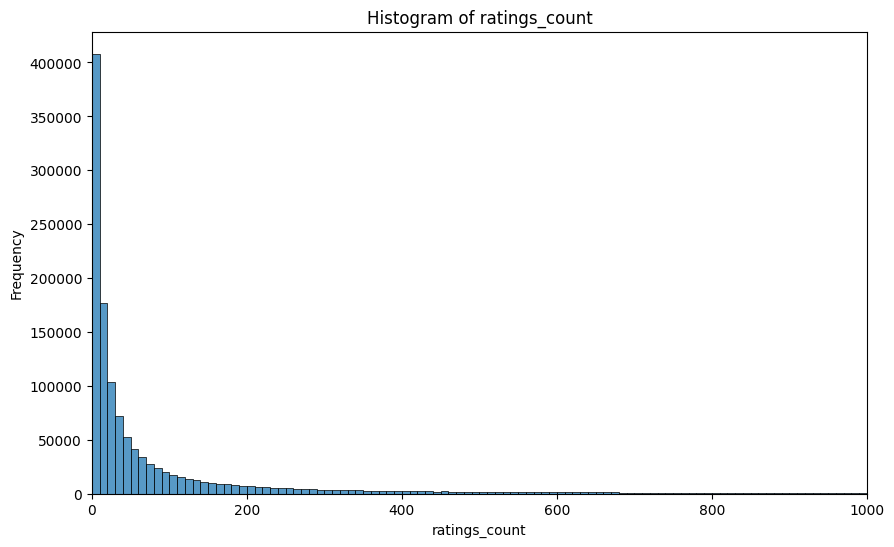

In [ ]:
histogram_plot(df_pandas, "ratings_count")

A histogram of ratings_count reveals a highly skewed distribution, where most books have received fewer than 50-60 ratings. The data is heavily concentrated in the lower end, with a long tail representing a small number of highly rated books.

In [ ]:
# Calculate and display key quantiles
# (25th, 50th, 75th, 90th, and 95th percentiles) for the 'ratings_count' column

df_pandas["ratings_count"].quantile([0.25, 0.5, 0.75, 0.9, 0.95])


,ratings_count
0.25,7.0
0.50,25.0
0.75,104.0
0.90,444.0
0.95,1173.0


In [ ]:
((df_pandas["ratings_count"] > 100) & (df_pandas["average_rating"]>3.0)).sum()

np.int64(326230)

In [ ]:
# Filter the dataset to keep only books with more than 100 ratings and an
# average rating greater than 3.0

df_pandas = df_pandas[((df_pandas["ratings_count"] > 100) & (df_pandas["average_rating"]>3.0))]

Reason:
 - Books with very few ratings may have unreliable feedback and are difficult for collaborative filtering models (cold start problem)
 - Books with low average ratings are generally less appealing to recommend
 - Reducing the dataset size improves computational efficiency: smaller matrices, faster training, and quicker similarity calculations
 This filtering ensures higher-quality data and makes the recommendation system more scalable and practical.

In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326230 entries, 511873 to 873373
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   title_without_series  326230 non-null  string 
 1   authors               326230 non-null  object 
 2   average_rating        326230 non-null  Float64
 3   ratings_count         326230 non-null  int64  
 4   book_id               326230 non-null  int64  
 5   popular_shelves       326230 non-null  object 
 6   similar_books         326230 non-null  object 
 7   language_code         326230 non-null  string 
 8   description           326230 non-null  string 
dtypes: Float64(1), int64(2), object(3), string(3)
memory usage: 289.7+ MB


In [ ]:
df_pandas.to_parquet("/content/drive/MyDrive/Book item-item/filtered_books_data_wrangled.parquet", index=False)

## Lammetized Data


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Book item-item/filtered_books_data_wrangled.parquet")

In [ ]:
df.head()

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description
0,"The Hunger Games (The Hunger Games, #1)",[153394],4.34,4899965,2767052,"[favorites, currently-reading, to-read, young-...","[1902241, 146499, 954674, 9917938, 10165727, 7...",eng,Winning will make you famous. Losing means cer...
1,Harry Potter and the Sorcerer's Stone (Harry P...,"[1077326, 2927]",4.45,4765497,3,"[to-read, favorites, fantasy, young-adult, fic...","[13830, 127586, 121822, 37586, 6164358, 807968...",eng,Harry Potter's life is miserable. His parents ...
2,"Twilight (Twilight, #1)",[941441],3.57,3941381,41865,"[to-read, young-adult, fantasy, favorites, vam...","[1326258, 140077, 35729, 30123413, 11260526, 9...",en-US,About three things I was absolutely positive. ...
3,To Kill a Mockingbird,[1825],4.26,3255518,2657,"[to-read, favorites, classics, classic, histor...","[1934, 2156, 15638, 53835, 77142, 5114, 116020...",eng,The unforgettable novel of a childhood in a sl...
4,The Great Gatsby,[3190],3.89,2758812,4671,"[to-read, classics, favorites, fiction, classi...","[48203, 337113, 176972, 188087, 10956, 12722, ...",eng,"THE GREAT GATSBY, F. Scott Fitzgerald's third ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326230 entries, 0 to 326229
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   title_without_series  326230 non-null  string 
 1   authors               326230 non-null  object 
 2   average_rating        326230 non-null  Float64
 3   ratings_count         326230 non-null  int64  
 4   book_id               326230 non-null  int64  
 5   popular_shelves       326230 non-null  object 
 6   similar_books         326230 non-null  object 
 7   language_code         326230 non-null  string 
 8   description           326230 non-null  string 
dtypes: Float64(1), int64(2), object(3), string(3)
memory usage: 22.7+ MB


In [ ]:
df.loc[7]["description"]

"The hero-narrator of The Catcher in the Ryeis an ancient child of sixteen, a native New Yorker named Holden Caulfield. Through circumstances that tend to preclude adult, secondhand description, he leaves his prep school in Pennsylvania and goes underground in New York City for three days. The boy himself is at once too simple and too complex for us to make any final comment about him or his story. Perhaps the safest thing we can say about Holden is that he was born in the world not just strongly attracted to beauty but, almost, hopelessly impaled on it. There are many voices in this novel: children's voices, adult voices, underground voices-but Holden's voice is the most eloquent of all. Transcending his own vernacular, yet remaining marvelously faithful to it, he issues a perfectly articulated cry of mixed pain and pleasure. However, like most lovers and clowns and poets of the higher orders, he keeps most of the pain to, and for, himself. The pleasure he gives away, or sets aside, w

###Lammetized Data




In [ ]:
import re, string, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

try:
  nlp = spacy.load("en_core_web_sm")
except OSError:
  print("SpaCy model 'en_core_web_sm' not found. Please run 'python -m spacy download en_core_web_sm'")
  nlp = None

STOPWORDS = set(stopwords.words("english"))

print("\nApplying tokenizer using nlp.pipe()...")
if nlp: # Only proceed if model loaded
    # nlp.pipe requires an iterable of strings.
    # Handle potential None/NaN in the original column by replacing with empty strings.
    descriptions_for_pipe = df['description'].fillna('').astype(str).tolist()

    # Process texts in batches using nlp.pipe
    # `disable=['parser', 'ner']` disables components we don't need for just lemmatization
    # which can speed things up if your model has those components.
    processed_docs = nlp.pipe(descriptions_for_pipe, disable=['parser', 'ner'])

    # Iterate through the processed docs and extract/filter lemmas
    lemmatized_tokens_pipe = []
    for doc in processed_docs:
        # Reapply the filtering logic to each processed doc
        tokens = [
             token.lemma_.lower()
             for token in doc
             if token.lemma_.lower() not in STOPWORDS
             and not token.is_punct
             and not token.is_space
             # Optional: Add check for short tokens
        ]
        lemmatized_tokens_pipe.append(tokens)

    # Assign the resulting list to a new column
    df['lemmatized_description_pipe'] = lemmatized_tokens_pipe

    print("\nDataFrame after nlp.pipe():")
    print(df[['book_id', 'description', 'lemmatized_description_pipe']])

else:
    print("Skipping nlp.pipe() because spaCy model failed to load.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Applying tokenizer using nlp.pipe()...

DataFrame after nlp.pipe():
         book_id                                        description  \
0        2767052  Winning will make you famous.
Losing means cer...   
1              3  Harry Potter's life is miserable. His parents ...   
2          41865  About three things I was absolutely positive.
...   
3           2657  The unforgettable novel of a childhood in a sl...   
4           4671  THE GREAT GATSBY, F. Scott Fitzgerald's third ...   
...          ...                                                ...   
326225  18363056  With evil lurking on every corner, can two ver...   
326226   1137199  A delightful collection of magical folk tales
...   
326227  34827846  "My one fear is now my reality."
He didn't off...   
326228  11114177  Why did the flushing toilet take two centuries...   
326229  12988686  Nate Whitney had always had a connection to na...   

                              lemmatized_description_pipe  
0       [win, make

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326230 entries, 0 to 326229
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         326230 non-null  string 
 1   authors                      326230 non-null  object 
 2   average_rating               326230 non-null  Float64
 3   ratings_count                326230 non-null  int64  
 4   book_id                      326230 non-null  int64  
 5   popular_shelves              326230 non-null  object 
 6   similar_books                326230 non-null  object 
 7   language_code                326230 non-null  string 
 8   description                  326230 non-null  string 
 9   lemmatized_description_pipe  326230 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 25.2+ MB


In [ ]:
parquet_file_path = "/content/drive/MyDrive/Book item-item/books_lemmatized_description.parquet"
try:
  df.to_parquet(parquet_file_path, index=False)
  print(f"DataFrame saved")
except Exception as e:
  print(f"Error saving DataFrame : {e}")

DataFrame saved


##Model Training

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326230 entries, 0 to 326229
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         326230 non-null  string 
 1   authors                      326230 non-null  object 
 2   average_rating               326230 non-null  Float64
 3   ratings_count                326230 non-null  int64  
 4   book_id                      326230 non-null  int64  
 5   popular_shelves              326230 non-null  object 
 6   similar_books                326230 non-null  object 
 7   language_code                326230 non-null  string 
 8   description                  326230 non-null  string 
 9   lemmatized_description_pipe  326230 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 25.2+ MB


In [ ]:
books_df.head()

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description,lemmatized_description_pipe
0,"The Hunger Games (The Hunger Games, #1)",[153394],4.34,4899965,2767052,"[favorites, currently-reading, to-read, young-...","[1902241, 146499, 954674, 9917938, 10165727, 7...",eng,Winning will make you famous. Losing means cer...,"[win, make, famous, losing, mean, certain, dea..."
1,Harry Potter and the Sorcerer's Stone (Harry P...,"[1077326, 2927]",4.45,4765497,3,"[to-read, favorites, fantasy, young-adult, fic...","[13830, 127586, 121822, 37586, 6164358, 807968...",eng,Harry Potter's life is miserable. His parents ...,"[harry, potter, 's, life, miserable, parent, d..."
2,"Twilight (Twilight, #1)",[941441],3.57,3941381,41865,"[to-read, young-adult, fantasy, favorites, vam...","[1326258, 140077, 35729, 30123413, 11260526, 9...",en-US,About three things I was absolutely positive. ...,"[three, thing, absolutely, positive, first, ed..."
3,To Kill a Mockingbird,[1825],4.26,3255518,2657,"[to-read, favorites, classics, classic, histor...","[1934, 2156, 15638, 53835, 77142, 5114, 116020...",eng,The unforgettable novel of a childhood in a sl...,"[unforgettable, novel, childhood, sleepy, sout..."
4,The Great Gatsby,[3190],3.89,2758812,4671,"[to-read, classics, favorites, fiction, classi...","[48203, 337113, 176972, 188087, 10956, 12722, ...",eng,"THE GREAT GATSBY, F. Scott Fitzgerald's third ...","[great, gatsby, f., scott, fitzgerald, 's, thi..."


In [ ]:
updated_books_df = books_df[(books_df['average_rating']>=4) & (books_df['ratings_count']>100)]

In [ ]:
updated_books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137572 entries, 0 to 326229
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         137572 non-null  string 
 1   authors                      137572 non-null  object 
 2   average_rating               137572 non-null  Float64
 3   ratings_count                137572 non-null  int64  
 4   book_id                      137572 non-null  int64  
 5   popular_shelves              137572 non-null  object 
 6   similar_books                137572 non-null  object 
 7   language_code                137572 non-null  string 
 8   description                  137572 non-null  string 
 9   lemmatized_description_pipe  137572 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 11.7+ MB


In [8]:
parquet_file_path = "/content/drive/MyDrive/Book item-item/135k_books_lemmatized_description.parquet"
try:
  updated_books_df.to_parquet(parquet_file_path, index = False)
  print("dataframe saved")
except Exception as e:
  print(f"Error saving Dataframe: {e}")

Error saving Dataframe: name 'updated_books_df' is not defined


In [ ]:
from IPython.display import Javascript

# This JS code will click the reconnect button every 60 000 ms (1 min)
js = """
function ClickConnect(){
  console.log("⏳ Keep-alive ping");
  document.querySelector("colab-connect-button")
          .shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect, 60000);
"""

display(Javascript(js))


<IPython.core.display.Javascript object>

##Building Ranking system using Whoosh

In [ ]:
token_lists = (
    books_df["lemmatized_description_pipe"]
      .apply(lambda arr: arr.tolist())      # ndarray → list[str]
      .tolist()                             # Series → list of docs
)
book_ids = books_df["book_id"].tolist()

In [ ]:
data        = [(int(b), toks)
               for b, toks in zip(book_ids, token_lists) if toks]
N_DOCS      = len(data)   # total number of books to process
N_DOCS

122224

In [ ]:
# 1. How long is each list?
print("len(book_ids)     =", len(book_ids))
print("len(token_lists)  =", len(token_lists))

# 2. How many token_lists entries are empty or falsey?
empty_count = sum(1 for toks in token_lists if not toks)
print("empty token_lists =", empty_count)

# 3. How many pairs does zip produce?
print("len(list(zip(book_ids, token_lists))) =",
      len(list(zip(book_ids, token_lists))))


len(book_ids)     = 137572
len(token_lists)  = 137572
empty token_lists = 15348
len(list(zip(book_ids, token_lists))) = 137572


In [ ]:
!pip install whoosh --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import os
import time
import math
import pickle
import multiprocessing as mp

from whoosh import index, scoring
from whoosh.fields import Schema, TEXT, ID
from whoosh.analysis import RegexTokenizer, LowercaseFilter
from whoosh.qparser import QueryParser
from tqdm import tqdm

# -------------------------
# 0) Configuration
# -------------------------
# Load and filter your data into a list of (book_id, tokens) pairs
token_lists = books_df["lemmatized_description_pipe"] \
                   .apply(lambda arr: arr.tolist()) \
                   .tolist()
book_ids    = books_df["book_id"].tolist()
# Keep only entries with non-empty token lists
data        = [(int(b), toks)
               for b, toks in zip(book_ids, token_lists) if toks]
N_DOCS      = len(data)   # total number of books to process

# Decide how many worker processes to launch
NUM_WORKERS    = mp.cpu_count()
# How often each worker will print a “heartbeat” status
PROGRESS_EVERY = 2000
# Directory for the on-disk Whoosh index
IDX_DIR        = "whoosh_idx_135k"
# Number of neighbors to fetch per query
TOP_K          = 100

print(f"Using {N_DOCS} books; launching {NUM_WORKERS} workers")

# -------------------------
# 1) Build the Whoosh index
# -------------------------
# Define the schema: an ID field for book_id and a TEXT field for description
my_lemmatized_analyzer = RegexTokenizer() | LowercaseFilter()
schema = Schema(
    book_id = ID(stored=True, unique=True),
    content = TEXT(stored=False, analyzer=my_lemmatized_analyzer)
)

# Create (or reuse) the index directory
os.makedirs(IDX_DIR, exist_ok=True)
ix = index.create_in(IDX_DIR, schema)

# Open a multi-process writer (leverages NUM_WORKERS threads)
writer = ix.writer(procs=NUM_WORKERS, limitmb=2048)

start_time = time.time()
for i, (bid, toks) in enumerate(data, start=1):
    # Add each document to the index
    # .join is done because the whoosh tokenizer expect the data as 1 big string.
    # this data will further broken and analysed in the selected analyzer
    writer.add_document(book_id=str(bid), content=" ".join(toks))
    # Periodically report progress and ETA
    if i % PROGRESS_EVERY == 0 or i == N_DOCS:
        elapsed = time.time() - start_time
        eta     = elapsed * (N_DOCS - i) / i
        print(f"Indexed {i}/{N_DOCS} docs — "
              f"{elapsed:.0f}s elapsed, ETA {eta/60:.1f}m",
              flush=True)
# Commit and close the writer
writer.commit()
print(f"Index build completed in {(time.time() - start_time)/60:.1f} minutes")

# -------------------------
# 2) Prepare data chunks
# -------------------------
# Split the list of documents into roughly equal chunks for each worker
chunk_size = math.ceil(N_DOCS / NUM_WORKERS)
chunks     = [data[i : i + chunk_size]
              for i in range(0, N_DOCS, chunk_size)]

# -------------------------
# 3) Define the worker
# -------------------------
def worker(chunk):
    """
    Each worker process:
    - Opens the shared Whoosh index
    - Initializes a BM25 searcher
    - Iterates over its assigned slice of (book_id, tokens)
    - Runs a BM25 query for each book’s tokens
    - Collects top-K neighbours (excluding itself) into a dict
    - Prints a heartbeat every PROGRESS_EVERY queries
    """
    ix       = index.open_dir(IDX_DIR)
    searcher = ix.searcher(weighting=scoring.BM25F(B=0.75, K1=1.5))
    qp       = QueryParser("content", schema=ix.schema)
    local    = {}
    start_w  = time.time()
    proc     = mp.current_process().name

    for idx, (bid, toks) in enumerate(chunk, start=1):
        # Build and execute the BM25 query
        q    = qp.parse(" ".join(toks))
        hits = searcher.search(q, limit=TOP_K)
        # Store neighbour list: (neighbour_id, score)
        local[bid] = [
            (int(h["book_id"]), h.score)
            for h in hits
            if int(h["book_id"]) != bid
        ]
        # Heartbeat: report progress within this worker’s chunk
        if idx % PROGRESS_EVERY == 0 or idx == len(chunk):
            elapsed = time.time() - start_w
            rate    = idx / elapsed
            eta     = (len(chunk) - idx) / rate
            print(f"{proc}: processed {idx}/{len(chunk)} — "
                  f"{elapsed:.0f}s elapsed, ETA {eta/60:.1f}m",
                  flush=True)
    return local

# -------------------------
# 4) Run parallel querying
# -------------------------
print("Starting parallel BM25 queries…")
t0 = time.time()
bm25_table = {}
# Use a process pool to run workers concurrently
with mp.Pool(NUM_WORKERS) as pool:
    # imap_unordered yields each worker’s result dict as it finishes
    for part in tqdm(pool.imap_unordered(worker, chunks), total=len(chunks)):
        # Merge partial results into the global table
        bm25_table.update(part)

total_time = time.time() - t0
print(f"Completed all {N_DOCS} queries in {total_time/60:.1f} minutes")

# -------------------------
# 5) Save the neighbour table
# -------------------------
out_path = "/content/drive/MyDrive/Book item-item/bm25_neighbors_135k_top100_custom_analyzer.pkl"
with open(out_path, "wb") as f:
    pickle.dump(bm25_table, f)
size_mb = os.path.getsize(out_path) / 2**20
print(f"Saved {len(bm25_table)} neighbour lists to {out_path} ({size_mb:.1f} MB)")


Using 122224 books; launching 8 workers
Indexed 2000/122224 docs — 0s elapsed, ETA 0.3m
Indexed 4000/122224 docs — 0s elapsed, ETA 0.1m
Indexed 6000/122224 docs — 0s elapsed, ETA 0.1m
Indexed 8000/122224 docs — 0s elapsed, ETA 0.1m
Indexed 10000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 12000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 14000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 16000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 18000/122224 docs — 2s elapsed, ETA 0.2m
Indexed 20000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 22000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 24000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 26000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 28000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 30000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 32000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 34000/122224 docs — 3s elapsed, ETA 0.1m
Indexed 36000/122224 docs — 3s elapsed, ETA 0.1m
Indexed 38000/122224 docs — 3s elapsed, ETA 0.1m
Indexed 40000/122224 docs — 3s el

  0%|          | 0/8 [00:00<?, ?it/s]

ForkPoolWorker-16: processed 2000/15278 — 1236s elapsed, ETA 136.7m
ForkPoolWorker-15: processed 2000/15278 — 1238s elapsed, ETA 137.0m
ForkPoolWorker-13: processed 2000/15278 — 1249s elapsed, ETA 138.2m
ForkPoolWorker-14: processed 2000/15278 — 1255s elapsed, ETA 138.9m
ForkPoolWorker-10: processed 2000/15278 — 1287s elapsed, ETA 142.4m
ForkPoolWorker-11: processed 2000/15278 — 1290s elapsed, ETA 142.7m
ForkPoolWorker-12: processed 2000/15278 — 1307s elapsed, ETA 144.6m
ForkPoolWorker-9: processed 2000/15278 — 1323s elapsed, ETA 146.4m
ForkPoolWorker-15: processed 4000/15278 — 2492s elapsed, ETA 117.1m
ForkPoolWorker-16: processed 4000/15278 — 2500s elapsed, ETA 117.5m
ForkPoolWorker-13: processed 4000/15278 — 2514s elapsed, ETA 118.2m
ForkPoolWorker-14: processed 4000/15278 — 2543s elapsed, ETA 119.5m
ForkPoolWorker-10: processed 4000/15278 — 2572s elapsed, ETA 120.9m
ForkPoolWorker-11: processed 4000/15278 — 2599s elapsed, ETA 122.2m
ForkPoolWorker-12: processed 4000/15278 — 2638s e

 12%|█▎        | 1/8 [2:42:22<18:56:36, 9742.43s/it]

ForkPoolWorker-15: processed 15278/15278 — 9790s elapsed, ETA 0.0m


 25%|██▌       | 2/8 [2:43:11<6:44:01, 4040.20s/it] 

ForkPoolWorker-14: processed 15278/15278 — 9827s elapsed, ETA 0.0m


 38%|███▊      | 3/8 [2:43:48<3:04:21, 2212.28s/it]

ForkPoolWorker-13: processed 15278/15278 — 9899s elapsed, ETA 0.0m


 50%|█████     | 4/8 [2:44:59<1:31:08, 1367.20s/it]

ForkPoolWorker-10: processed 15278/15278 — 9951s elapsed, ETA 0.0m


 62%|██████▎   | 5/8 [2:45:51<44:38, 892.92s/it]   

ForkPoolWorker-12: processed 15278/15278 — 10015s elapsed, ETA 0.0m


 75%|███████▌  | 6/8 [2:46:55<20:22, 611.04s/it]

ForkPoolWorker-11: processed 15278/15278 — 10024s elapsed, ETA 0.0m


 88%|████████▊ | 7/8 [2:47:04<06:54, 414.03s/it]

ForkPoolWorker-9: processed 15278/15278 — 10052s elapsed, ETA 0.0m


100%|██████████| 8/8 [2:47:32<00:00, 1256.56s/it]

Completed all 122224 queries in 167.5 minutes
Saved 122224 neighbour lists to /content/drive/MyDrive/Book item-item/bm25_neighbors_135k_top100_custom_analyzer.pkl (1.3 MB)


The problem here is, even though all books had description, using BM25 model on building recommendations on Description feature resulted in no recommendations for many books. this might be because, there are many dissimilar books or BM25 failed to see any similarity in it.
this probably happened because, i use keyword analyser in Whoosh retrival system. Keyword analyser treets the whole discription as 1 atring and tries to find similarity. however this is not suitable for description which has a lot of strings, Keyword analyse is best for data like titles, genres ets. so Building custom analyser did not improve the results much. out of 122224 data, only 13138 had recommendations which is just slightly higher than 12924 recommendations from keyword analyzer.
Tried just using description field of data and let the whoosh analyser do the lemmatizing and lowercasing an other work but this take lot of execution time. approx 12 hours. so aborted and tring sentense transformer to get semantic meaning


In [12]:
import pandas as pd
file_path = "/content/drive/MyDrive/Book item-item/135k_books_lemmatized_description.parquet"
try:
  books_df = pd.read_parquet(file_path)
  print("Dataframe loaded")
except Exception as e:
  print(f"error loadinf {e}")

Dataframe loaded


In [13]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137572 entries, 0 to 137571
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         137572 non-null  string 
 1   authors                      137572 non-null  object 
 2   average_rating               137572 non-null  Float64
 3   ratings_count                137572 non-null  int64  
 4   book_id                      137572 non-null  int64  
 5   popular_shelves              137572 non-null  object 
 6   similar_books                137572 non-null  object 
 7   language_code                137572 non-null  string 
 8   description                  137572 non-null  string 
 9   lemmatized_description_pipe  137572 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 10.6+ MB


In [18]:
books_df["popular_shelves"].iloc[1]

array(['to-read', 'favorites', 'fantasy', 'young-adult', 'fiction',
       'harry-potter', 'books-i-own', 'owned', 'ya', 'series',
       'favourites', 'magic', 'childrens', 're-read', 'children',
       'adventure', 'owned-books', 'classics', 'children-s', 'childhood',
       'middle-grade', 'reread', 'all-time-favorites', 'j-k-rowling',
       'sci-fi-fantasy', 'children-s-books', 'my-books', 'kids',
       'audiobook', 'favorite-books', 'default', 'audiobooks', 'novels',
       '5-stars', 'i-own', 'favorite', 'read-in-2016', 'fantasy-sci-fi',
       'paranormal', 'read-more-than-once', 're-reads', 'my-library',
       'read-in-2015', 'books', 'english', 'ya-fantasy', 'read-in-2017',
       'childrens-books', 'british', 'urban-fantasy', 'mystery', 'teen',
       'audio', 'favorite-series', 'library', 'supernatural',
       'my-favorites', 'read-in-2014', 'novel', 'faves', 'jk-rowling',
       'own-it', 'ya-fiction', 'harry-potter-series', 'kindle',
       'juvenile', 'childhood-favor

In [4]:
import pickle
with open("/content/drive/MyDrive/Book item-item/bm25_neighbors_135k_top100.pkl", "rb") as f:
  bm25_table = pickle.load(f)

In [5]:
empty_count = sum(1 for list in bm25_table.values() if not list)

In [6]:
type(bm25_table)

dict

In [7]:
bm25_table


{17130546: [],
 18756844: [],
 27571369: [],
 58963: [(8534091, 180.32747726066046)],
 21453562: [],
 180090: [],
 28782949: [],
 839075: [],
 33197725: [],
 22529224: [],
 24973792: [],
 15854661: [(15854588, 512.012408913791),
  (15854584, 512.012408913791),
  (15854579, 512.012408913791),
  (15854613, 512.012408913791),
  (15854684, 512.012408913791),
  (15854640, 512.012408913791),
  (15854641, 512.012408913791),
  (15854642, 512.012408913791),
  (15854842, 512.012408913791),
  (15854587, 512.012408913791),
  (15854611, 512.012408913791),
  (15854627, 512.012408913791),
  (15854726, 512.012408913791),
  (15854583, 512.012408913791),
  (15854615, 512.012408913791),
  (15854610, 512.012408913791),
  (15854617, 512.012408913791),
  (15854625, 512.012408913791),
  (15854631, 512.012408913791),
  (15854885, 512.012408913791),
  (15854847, 512.012408913791),
  (15854619, 512.012408913791),
  (15854624, 512.012408913791),
  (15854644, 512.012408913791),
  (15854851, 512.012408913791),
  (

In [ ]:
print(empty_count)

109300


In [ ]:
len(bm25_table) - empty_count

12924

##Using Sentence Transformer

In [ ]:
import pandas as pd
try:
  books_df = pd.read_parquet("/content/drive/MyDrive/Book item-item/135k_books_lemmatized_description.parquet")
except Exception as e:
  print(f"Error loading Dataframe: {e}")
except FileNotFoundError as e:
  print(f"Error loading Dataframe: {e}")

In [ ]:
!pip install sentence_transformers faiss-cpu tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from sentence_transformers import  SentenceTransformer
import numpy as np
import faiss
from tqdm import tqdm

In [ ]:
# books_df["book_id"] is a panda series. this will have index so to extract the values,
# .values is called. converting it to numpy array since NumPy array is more compact in
# memory and has faster indexing than a Python list. and also makes sure all the
# values will be int
book_ids = books_df["book_id"].values.astype(np.int64)

In [ ]:
description = books_df["description"].tolist()

In [ ]:
# filter to only contain fields with description
data = [(bid, desc) for bid, desc in zip(book_ids, description) if desc]

In [ ]:
len(data)

122227

In [ ]:
filtered_ids = [bid for bid, _ in data]
filtered_desc = [desc for _, desc in data]

In [ ]:
filtered_ids = np.array(filtered_ids, np.int64)

In [ ]:
N = len(filtered_desc)